<a href="https://colab.research.google.com/github/priyaking3803-tech/DS_Diamond-Dynamics/blob/main/Tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the required Libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Using the GPU

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/Labeled MRI Brain Tumor Dataset.v1-version-1.multiclass.zip'

# Destination path to extract
extract_path = '/content/drive/MyDrive/Tumour'

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [ ]:
train_dir = '/content/drive/MyDrive/Tumour/train'
val_dir = '/content/drive/MyDrive/Tumour/valid'
test_dir = "/content/drive/MyDrive/Tumour/test"

# Data Augumentation

In [ ]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]

    # Data augmentation parameters
    rotation_range=20,  # Random rotation between -20 and +20 degrees
    width_shift_range=0.2,  # Random horizontal shift by ±20% of width
    height_shift_range=0.2,  # Random vertical shift by ±20% of height
    zoom_range=0.2,  # Random zoom between 80% and 120%
    horizontal_flip=True,  # Random horizontal flipping
    vertical_flip=False,  # No vertical flipping (can enable if appropriate)
    fill_mode='nearest'  # Strategy for filling in newly created pixels
)

# Validation and test generators (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Set image size and batch size
img_width, img_height = 224, 224  # Adjust as needed
batch_size = 32  # Adjust as needed

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # or 'binary' if you have two classes
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluating the test set
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# Get the classnames and number of classes

In [ ]:
test_generator.class_indices

{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

In [ ]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

Class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


# Building a custom model

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 738s 14s/step - accuracy: 0.3990 - loss: 1.5082 - precision: 0.4224 - recall: 0.0763 - val_accuracy: 0.4563 - val_loss: 1.1282 - val_precision: 0.5092 - val_recall: 0.2875
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.5625 - loss: 0.9795 - precision: 0.7222 - recall: 0.4062

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.5625 - loss: 0.9795 - precision: 0.7222 - recall: 0.4062 - val_accuracy: 0.3958 - val_loss: 1.2614 - val_precision: 0.4118 - val_recall: 0.2479
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 595ms/step - accuracy: 0.6020 - loss: 1.0156 - precision: 0.7109 - recall: 0.3479 - val_accuracy: 0.6792 - val_loss: 0.7962 - val_precision: 0.7635 - val_recall: 0.5312
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6250 - loss: 0.7880 - precision: 0.8182 - recall: 0.5625 - val_accuracy: 0.6896 - val_loss: 0.8151 - val_precision: 0.8231 - val_recall: 0.4750
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 637ms/step - accuracy: 0.6252 - loss: 0.8784 - precision: 0.7632 - recall: 0.4923 - val_accuracy: 0.7354 - val_loss: 0.7037 - val_precision: 0.7903 - val_recall: 0.6438
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5625 - loss: 0.9541 - precision: 0.6250 - recall: 0.4688 - val_accuracy: 0.7521 - val_loss: 0.6556 - val

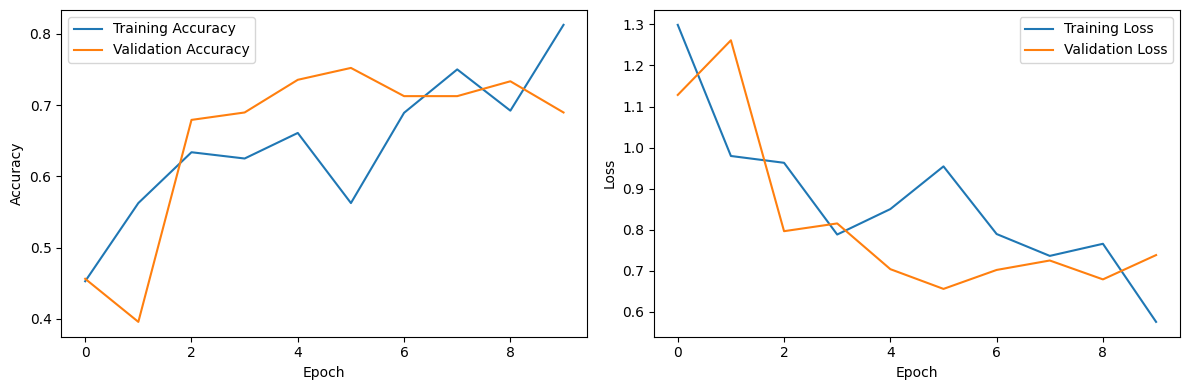

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step - accuracy: 0.6790 - loss: 0.7871 - precision: 0.7778 - recall: 0.5931

Test accuracy: 0.6870
Test precision: 0.7701
Test recall: 0.5854


In [ ]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step


In [ ]:
true_classes = test_generator.classes

In [ ]:
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=class_names))

# Confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\nConfusion Matrix:')
print(conf_mat)


Classification Report:
              precision    recall  f1-score   support

      glioma       0.88      0.71      0.79        80
  meningioma       0.61      0.56      0.58        63
    no_tumor       0.53      0.94      0.68        49
   pituitary       0.84      0.57      0.68        54

    accuracy                           0.69       246
   macro avg       0.71      0.70      0.68       246
weighted avg       0.73      0.69      0.69       246


Confusion Matrix:
[[57 18  4  1]
 [ 5 35 19  4]
 [ 1  1 46  1]
 [ 2  3 18 31]]


# Using Transfer Learning models

In [ ]:
from tensorflow.keras.applications import (VGG16, ResNet50, MobileNet,
                                          InceptionV3, EfficientNetB0)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison = []

# 1. VGG16

In [ ]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.3304 - loss: 1.4060 - precision: 0.3580 - recall: 0.0392 - val_accuracy: 0.5319 - val_loss: 1.2025 - val_precision: 0.9459 - val_recall: 0.0697
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 36s 672ms/step - accuracy: 0.4648 - loss: 1.2142 - precision: 0.8360 - recall: 0.0967 - val_accuracy: 0.6016 - val_loss: 1.0905 - val_precision: 0.7805 - val_recall: 0.1912
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 631ms/step - accuracy: 0.5516 - loss: 1.0950 - precision: 0.7981 - recall: 0.2069 - val_accuracy: 0.6594 - val_loss: 1.0159 - val_precision: 0.8446 - val_recall: 0.2490
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 627ms/step - accuracy: 0.6095 - loss: 1.0251 - precision: 0.8148 - recall: 0.2517 - val_accuracy: 0.6833 - val_loss: 0.9496 - val_precision: 0.8323 - val_recall: 0.2669
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 641ms/step - accuracy: 0.6462 - loss: 0.9777 - precision: 0.8058 -

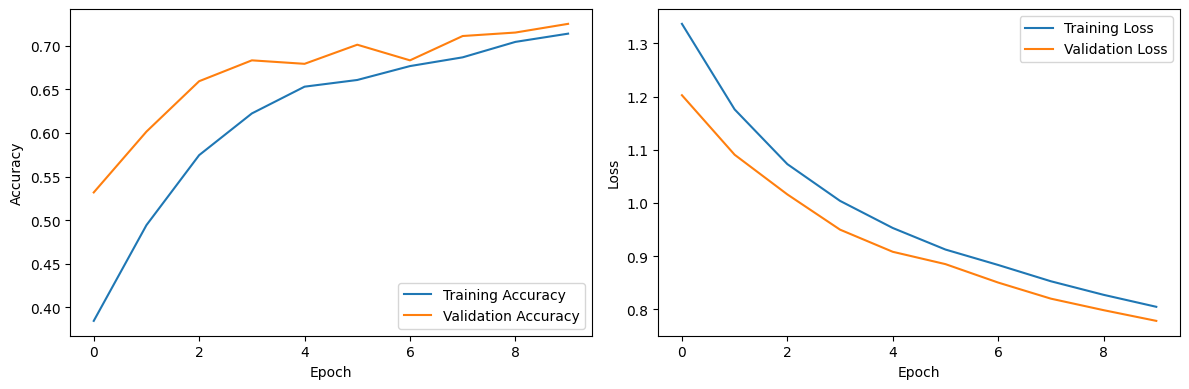

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - accuracy: 0.7070 - loss: 0.7559 - precision: 0.8873 - recall: 0.5289

Test accuracy: 0.7195
Test precision: 0.8849
Test recall: 0.5000
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step


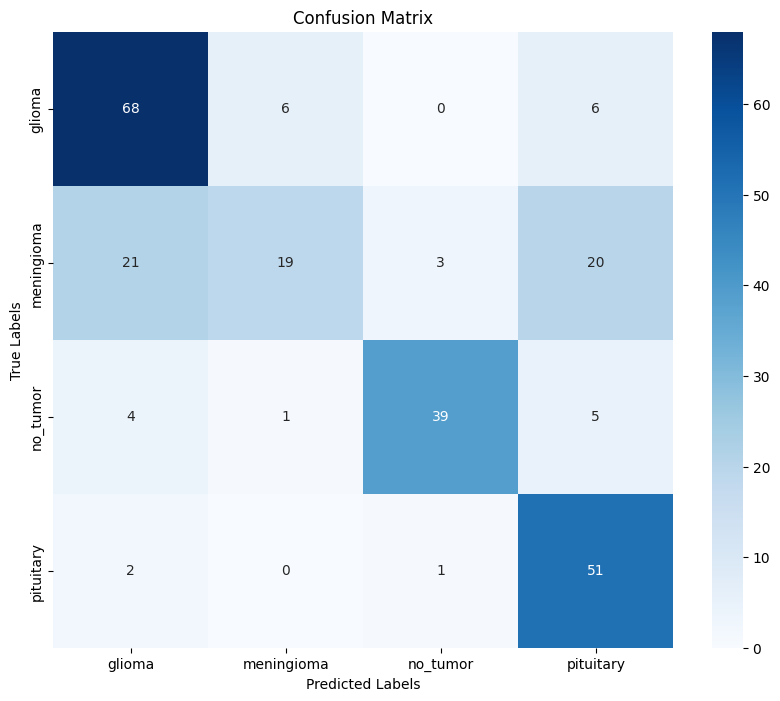

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(vgg_history)


# Evaluate on test set (assuming you have a test_generator)
test_generator.reset() # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f'\nTest accuracy: {test_acc:.4f}')
print(f'Test precision: {test_precision:.4f}')
print(f'Test recall: {test_recall:.4f}')


# Generate predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion Matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 2. RESNET50

In [ ]:
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 60s 846ms/step - accuracy: 0.3020 - loss: 1.4301 - precision: 0.3376 - recall: 0.0275 - val_accuracy: 0.4024 - val_loss: 1.2593 - val_precision: 0.7857 - val_recall: 0.0438
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 610ms/step - accuracy: 0.3697 - loss: 1.2923 - precision: 0.6154 - recall: 0.0439 - val_accuracy: 0.4363 - val_loss: 1.2309 - val_precision: 0.7475 - val_recall: 0.1474
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 583ms/step - accuracy: 0.4278 - loss: 1.2606 - precision: 0.6086 - recall: 0.0915 - val_accuracy: 0.5159 - val_loss: 1.1913 - val_precision: 0.8113 - val_recall: 0.0857
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 586ms/step - accuracy: 0.4445 - loss: 1.2211 - precision: 0.7467 - recall: 0.1114 - val_accuracy: 0.6155 - val_loss: 1.1679 - val_precision: 0.8636 - val_recall: 0.0757
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 34s 636ms/step - accuracy: 0.4795 - loss: 1.1997 - precision: 0.685

# 3. MobileNet

In [ ]:
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 45s 680ms/step - accuracy: 0.4400 - loss: 1.3543 - precision: 0.4895 - recall: 0.2965 - val_accuracy: 0.7849 - val_loss: 0.5696 - val_precision: 0.8410 - val_recall: 0.6952
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 609ms/step - accuracy: 0.7483 - loss: 0.6413 - precision: 0.8201 - recall: 0.6815 - val_accuracy: 0.8068 - val_loss: 0.4740 - val_precision: 0.8584 - val_recall: 0.7729
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 533ms/step - accuracy: 0.8198 - loss: 0.4629 - precision: 0.8595 - recall: 0.7699 - val_accuracy: 0.8307 - val_loss: 0.4366 - val_precision: 0.8712 - val_recall: 0.7948
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.8571 - loss: 0.4005 - precision: 0.8897 - recall: 0.8199 - val_accuracy: 0.8785 - val_loss: 0.3310 - val_precision: 0.9051 - val_recall: 0.8546
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 588ms/step - accuracy: 0.8701 - loss: 0.3838 - precision: 0.894

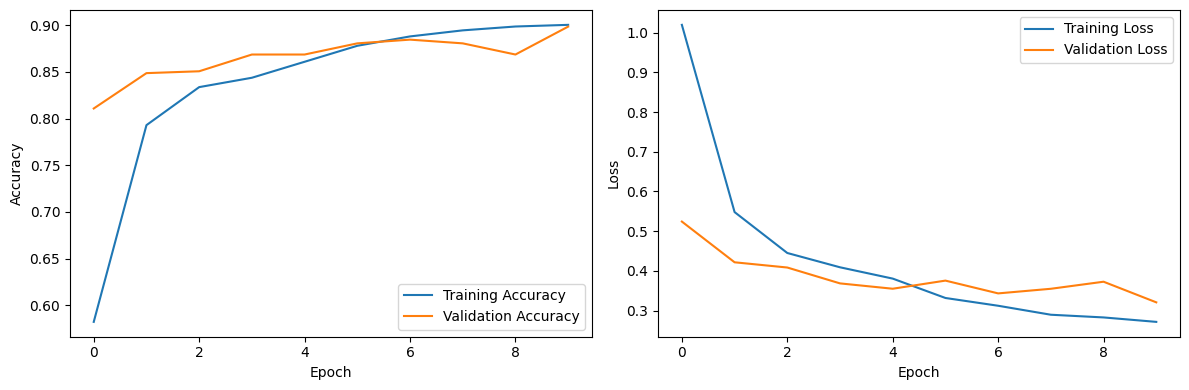

In [ ]:
plot_history(mobilenet_history)

In [ ]:
test_generator.reset()  # Reset the generator before evaluating
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f'\nMobileNet Test accuracy: {test_acc:.4f}')
print(f'MobileNet Test precision: {test_precision:.4f}')
print(f'MobileNet Test recall: {test_recall:.4f}')

# Generate predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes for MobileNet
true_classes = test_generator.classes

# Confusion Matrix for MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('MobileNet Confusion Matrix')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.8572 - loss: 0.3141 - precision: 0.8751 - recall: 0.8519

MobileNet Test accuracy: 0.8374
MobileNet Test precision: 0.8608
MobileNet Test recall: 0.8293
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 357ms/step


NameError: name 'sns' is not defined

<Figure size 1000x800 with 0 Axes>

# 4. InceptionV3

In [ ]:
def evaluate_inception():
    # Special generator for Inception's 299x299 input
    inception_train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=(299, 299), batch_size=batch_size)
    inception_val_gen = val_datagen.flow_from_directory(
        val_dir, target_size=(299, 299), batch_size=batch_size)

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(299, 299, 3))
    x = tf.keras.applications.inception_v3.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        inception_train_gen,
        validation_data=inception_val_gen,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

inception_model, inception_history = evaluate_inception()
model_comparison.append({
    'Model': 'InceptionV3',
    'Val Accuracy': max(inception_history.history['val_accuracy']),
    'Val Precision': max(inception_history.history['val_precision']),
    'Val Recall': max(inception_history.history['val_recall']),
    'Parameters': f"{inception_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Multi-scale features'
})

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3916 - loss: 1.3263 - precision: 0.5272 - recall: 0.0652 - val_accuracy: 0.4143 - val_loss: 1.2344 - val_precision: 0.6173 - val_recall: 0.0996
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 924ms/step - accuracy: 0.4533 - loss: 1.2111 - precision: 0.6609 - recall: 0.1284 - val_accuracy: 0.5239 - val_loss: 1.1599 - val_precision: 0.6742 - val_recall: 0.1773
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 925ms/step - accuracy: 0.5104 - loss: 1.1594 - precision: 0.6922 - recall: 0.1841 - val_accuracy: 0.5159 - val_loss: 1.1477 - val_precision: 0.7115 - val_recall: 0.2211
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 923ms/step - accuracy: 0.5324 - loss: 1.1405 - precision: 0.7107 - recall: 0.2014 - val_accuracy: 0.5717 - val_loss: 1.0717 - val_precision: 0.7688 - val_recall: 0.2849
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 910ms/step - accuracy: 0.5187 - loss: 1.1176 - precision: 0.7736 - recall: 0.2334 - val_accuracy: 0.5876 - val_loss: 

# 5. EfficientNet

In [ ]:
def evaluate_efficientnet():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data= validation_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

efficientnet_model, efficientnet_history = evaluate_efficientnet()
model_comparison.append({
    'Model': 'EfficientNetB0',
    'Val Accuracy': max(efficientnet_history.history['val_accuracy']),
    'Val Precision': max(efficientnet_history.history['val_precision']),
    'Val Recall': max(efficientnet_history.history['val_recall']),
    'Parameters': f"{efficientnet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Best accuracy/efficiency tradeoff'
})

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.3107 - loss: 1.3865 - precision: 0.2531 - recall: 9.0152e-04 - val_accuracy: 0.3207 - val_loss: 1.3714 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - accuracy: 0.2948 - loss: 1.3866 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3207 - val_loss: 1.3748 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 41s 573ms/step - accuracy: 0.3165 - loss: 1.3871 - precision: 0.4444 - recall: 0.0012 - val_accuracy: 0.3207 - val_loss: 1.3846 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.2918 - loss: 1.3898 - precision: 0.3648 - recall: 0.0027 - val_accuracy: 0.3207 - val_loss: 1.3737 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


# Models comparison

In [ ]:
import pandas as pd
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.898406,0.905544,0.878486,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.725100,0.945946,0.486056,"14,716,740",Medium,Medium-sized datasets
1,ResNet50,0.639442,0.863636,0.223108,"23,595,908",Medium,General purpose
3,InceptionV3,0.627490,0.792899,0.406375,"21,810,980",Medium,Multi-scale features
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


In [ ]:
comparison_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.898406,0.905544,0.878486,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.725100,0.945946,0.486056,"14,716,740",Medium,Medium-sized datasets
2,ResNet50,0.639442,0.863636,0.223108,"23,595,908",Medium,General purpose
3,InceptionV3,0.627490,0.792899,0.406375,"21,810,980",Medium,Multi-scale features
4,EfficientNetB0,0.320717,0.000000,0.000000,"4,054,695",Fast,Best accuracy/efficiency tradeoff


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.898406
Val Precision                0.905544
Val Recall                   0.878486
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


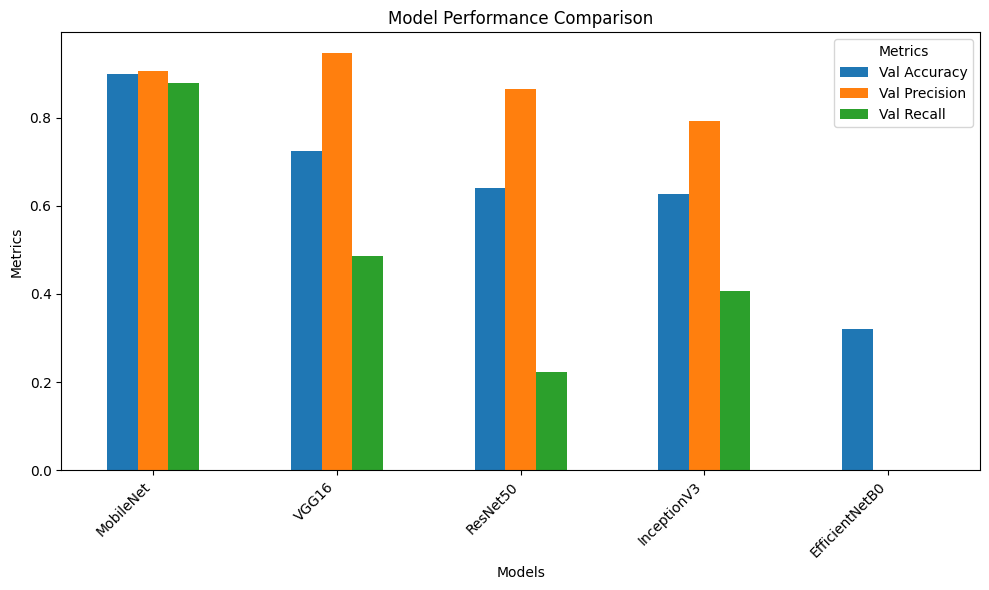

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/drive/MyDrive/model_comparison.csv')


# Find the best model based on validation accuracy
best_model = df.loc[df['Val Accuracy'].idxmax()]

print(f"The best performing model is:\n{best_model}")

# Plotting the bar chart
plt.figure(figsize=(10, 6))
df.plot(x='Model', y=['Val Accuracy', 'Val Precision', 'Val Recall'], kind='bar', ax=plt.gca())
plt.title('Model Performance Comparison')
plt.ylabel('Metrics')
plt.xlabel('Models')


plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Save the model

In [ ]:
mobilenet_model.save('/content/drive/MyDrive/model.h5')

# Streamlit App

In [ ]:
!pip install streamlit numpy pillow tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os


classes = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

# Load the trained model
@st.cache_resource
def load_custom_model():
    model_path = '/content/drive/MyDrive/model.h5'
    if not os.path.exists(model_path):
        st.error(f"Model file not found at {model_path}")
        return None
    return load_model(model_path)

model = load_custom_model()

# Streamlit app
st.title("🎣 Custom Brain Tumour Classifier")
st.write(f"Upload a Tumour to classify")

# File uploader
uploaded_file = st.file_uploader("Choose an image...",
                                type=["jpg", "jpeg", "png"])

if uploaded_file is not None and model is not None:
    # Display the uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess the image
    image = image.resize((224, 224))  # Match your model's expected input
    image_array = img_to_array(image)
    image_array = image_array / 255.0  # Normalize (if your model expects this)
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    with st.spinner('Identifying Tumour...'):
        predictions = model.predict(image_array)
        predicted_class = classes[np.argmax(predictions)]
        confidence = np.max(predictions)


    # Display results
    st.subheader("Predicted Results:")
    st.success(f"Tumour: {predicted_class}")
    st.info(f"Confidence: {confidence*100:.2f}%")

    # Show all class probabilities
    st.subheader("All Class Probabilities:")
    for i, (cls, prob) in enumerate(zip(classes, predictions[0])):
        st.write(f"{cls}: {prob*100:.2f}%")
        st.progress(float(prob))

Writing app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.16.134.16


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.16.134.16:8501

⠧⠇⠏⠋⠙⠹Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇your url is: https://yellow-singers-add.loca.lt
2025-08-01 08:31:48.131615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754037108.156142   13123 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754037108.163731   13123 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-01 08:31:52.761780: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding ori